In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor

# Model performance metric 
The target variables, bv and pc (i.e mercury volume and pressure) use different scales: pressure scale is 3 orders of magnitude larger. So the variables and their prediction errors are not comparable. Moreover, pressure and volume themselves vary across wide ranges (also a few order of magnitude wide). Therefore, I use mean average percentage error to evaluage model performance. 

# Data preparation
- Group is a sequential well number that does not have physical sense. It is also uniquely defined by well coordinates. So I drop this column.
- Well coordinates as such also do not determine anything but relative well proximity to each other can result in similarities, so I keep them in.
- Same sample numbers across different wells do not result in any similarity so I drop this column as well.
- The only categorical feature (and a very important one) is lithology, so I will one-hot encode it.
- All others will be standardized as usual.

In [2]:
train = pd.read_csv('train.csv'); train

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [3]:
X = train.iloc[:, :20]; X

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,2442.840273,2318.618853,6.425410,0.106890,5.658985,18985,5423,limestone,37.738168,2.664759
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,3035.549168,2729.578887,14.300516,0.718312,4.483886,16790,3644,shale,42.371106,2.760788
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,2085.069195,2747.971468,12.825353,0.639979,6.349391,18985,5423,sandstone,42.931089,2.624635
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,2016.024319,2546.626337,13.320168,0.288901,3.819145,18985,5423,limestone,39.485022,2.634539
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,1943.089817,1561.393112,7.183351,0.500868,6.593625,16169,5288,siltstome,34.846060,2.459622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,2439.147140,2089.051532,41.015660,0.709441,7.313445,19850,3873,limestone,30.240244,2.562103
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,2256.546050,2663.343376,1.366440,0.554834,8.669671,19850,3873,limestone,14.771108,2.617332
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,2281.831720,2071.560649,3.371203,0.786869,4.971094,16169,5288,sandstone,41.162699,2.687207
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,2400.377198,2512.672454,16.081238,0.671111,7.022591,19850,3873,sandstone,37.093964,2.653836


In [4]:
y = train.iloc[:, 20:]; y

,bv_0,bv_1,bv_2,bv_3,bv_4,bv_5,bv_6,bv_7,bv_8,bv_9,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,8.314193e-30,0.022937,0.175831,0.343738,0.457215,0.544975,0.619610,0.668326,0.714923,0.758957,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,8.404712e-30,0.065743,0.110847,0.149221,0.182478,0.207055,0.251148,0.264525,0.286616,0.296471,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,9.628115e-30,0.065462,0.126050,0.185575,0.236476,0.276897,0.326915,0.352935,0.379736,0.399494,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,1.001518e-29,0.035238,0.135762,0.260780,0.354239,0.437589,0.512409,0.573600,0.627993,0.674529,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,1.003009e-29,0.064098,0.117940,0.167830,0.213313,0.245085,0.286452,0.302900,0.324897,0.341102,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,8.405910e-30,0.011935,0.266474,0.392014,0.488393,0.561142,0.629793,0.674519,0.721665,0.761462,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,9.770500e-30,0.035415,0.148900,0.262791,0.349767,0.428302,0.524900,0.561232,0.611864,0.654517,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,9.858864e-30,0.035401,0.105316,0.252543,0.343569,0.436199,0.520484,0.579677,0.666790,0.735258,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,1.020829e-29,0.035444,0.181987,0.246770,0.296267,0.331121,0.381807,0.402956,0.436622,0.463018,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


In [13]:
class Preprocess():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        df = X.copy().drop(columns=['group', 'sample'])
        self.numeric_cols = df.select_dtypes(include='number').columns
        self.categoric_cols = df.select_dtypes(include='object').columns

        ct = ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', drop=None), self.categoric_cols),
                ('scale', StandardScaler(), self.numeric_cols)
            ],
            n_jobs=-1
        )
        self.transf = ct.fit(df)
        self.features = ct.get_feature_names_out()
        return self
    
    def transform(self, X, y=None):
        df = X.copy().drop(columns=['group', 'sample'])
        return pd.DataFrame(self.transf.transform(df), columns=self.features)


In [14]:
prep = Preprocess().fit(X)

In [16]:
X_prep = prep.transform(X)

In [17]:
X_prep

,onehot__lithology_clay sandstone,onehot__lithology_limestone,onehot__lithology_sandstone,onehot__lithology_shale,onehot__lithology_siltstome,scale__depth,scale__por,scale__den,scale__ct_1,scale__ct_2,...,scale__ct_5,scale__ct_6,scale__ct_7,scale__permeability,scale__ntg,scale__thickness_effective,scale__x,scale__y,scale__gr,scale__rhob
0,0.0,1.0,0.0,0.0,0.0,-1.497434,0.249045,-0.111626,-1.219575,0.003803,...,-1.089198,0.048238,-0.201495,-0.452414,-1.788082,-0.135881,0.509146,1.483051,0.025396,0.362979
1,0.0,0.0,0.0,1.0,0.0,1.580383,-0.766025,1.035027,0.411760,1.682853,...,1.173064,1.738182,1.012327,0.090066,1.077963,-0.888972,-0.943063,-0.766753,0.518081,1.311781
2,0.0,0.0,1.0,0.0,0.0,-0.631928,-1.651635,0.139207,-0.306337,-3.639227,...,-0.075200,-0.971846,1.066651,-0.011551,0.710776,0.306582,0.509146,1.483051,0.577632,-0.033471
3,0.0,1.0,0.0,0.0,0.0,-0.828762,1.227167,-1.374409,-1.807858,-0.057228,...,1.533560,-1.168708,0.471953,0.022535,-0.934904,-1.314987,0.509146,1.483051,0.211163,0.064386
4,0.0,0.0,0.0,0.0,1.0,1.392278,-1.214581,1.834544,-1.773216,-1.393946,...,-0.476158,-1.376661,-2.438056,-0.400203,0.058696,0.463106,-1.353916,1.312324,-0.282163,-1.663863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.0,1.0,0.0,0.0,0.0,-0.894639,-0.134112,-0.752990,0.239044,0.235264,...,-0.031902,0.037708,-0.879551,1.930351,1.036382,0.924420,1.081429,-0.477149,-0.771965,-0.651311
451,0.0,1.0,0.0,0.0,0.0,-0.920645,0.333181,-0.801132,-0.999735,-0.951913,...,-0.136547,-0.482928,0.816692,-0.800904,0.311661,1.793590,1.081429,-0.477149,-2.417016,-0.105620
452,0.0,0.0,1.0,0.0,0.0,1.279068,1.064050,0.268330,-1.011535,0.493444,...,-0.150363,-0.410833,-0.931212,-0.662805,1.399327,-0.576732,-1.353916,1.312324,0.389574,0.584775
453,0.0,0.0,1.0,0.0,0.0,-0.898133,0.088844,-0.540626,0.647638,-0.277197,...,0.895754,-0.072833,0.371666,0.212732,0.856709,0.738019,1.081429,-0.477149,-0.043112,0.255056


# Baseline model. Ordinary least squares linear regression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_prep, y,
                                                  test_size=0.2,
                                                  random_state=8,
                                                  shuffle=True)


In [20]:
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [21]:
y_pred = lr.predict(X_val)

In [22]:
mean_absolute_percentage_error(y_val, y_pred)

0.2768014284856145

In [25]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred[0,101:])

0.03497651799600717

In [26]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred[0,:101])

0.19556070562637717

Pressure values must increase consequtively

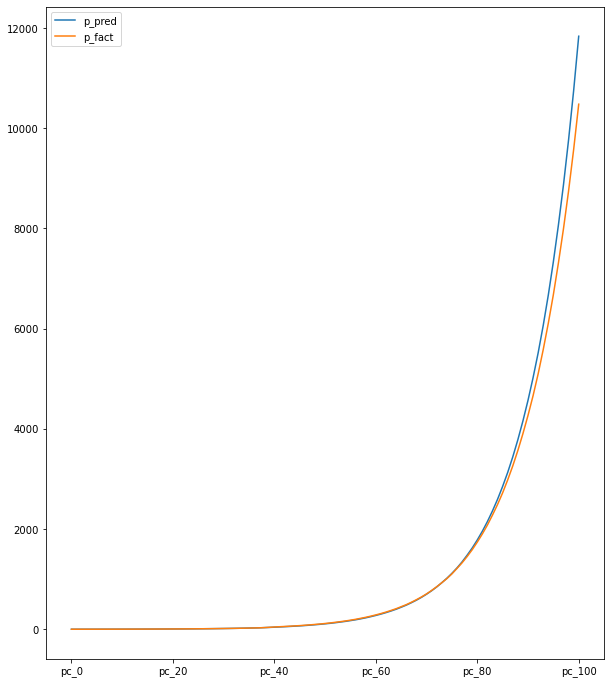

In [23]:
pd.DataFrame({'p_pred':y_pred[0,101:], 'p_fact': y_val.iloc[0,101:]}).plot.line(figsize=(10,12));

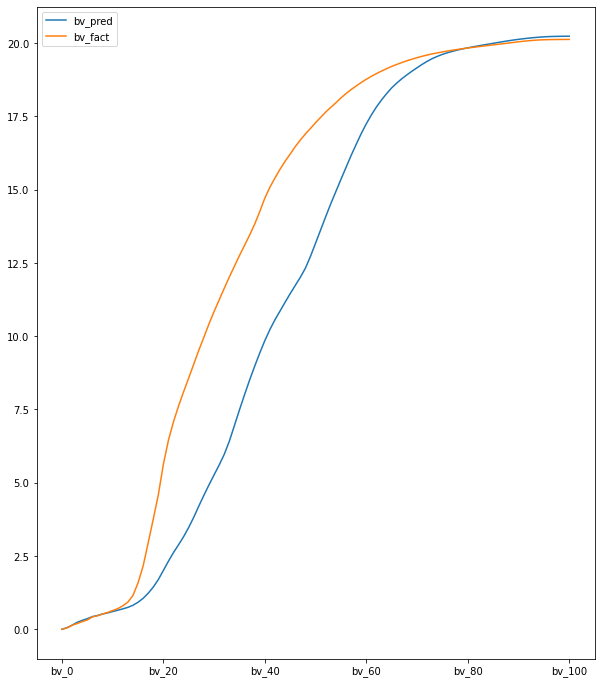

In [24]:
pd.DataFrame({'bv_pred':y_pred[0,:101], 'bv_fact': y_val.iloc[0,:101]}).plot.line(figsize=(10,12));

There is a much better match between pressure curves, likely because pressure has higher importance due to larger scale.

Feature importance:

In [36]:
feature_importance = pd.DataFrame(lr.coef_, columns = X_prep.columns).mean(axis=0).abs().sort_values(ascending=False)
feature_importance

scale__depth                        950.292675
onehot__lithology_clay sandstone    213.148077
onehot__lithology_limestone         153.874112
onehot__lithology_sandstone         104.891414
onehot__lithology_shale             103.626321
onehot__lithology_siltstome          58.008872
scale__ct_6                          22.731642
scale__den                           22.466791
scale__por                           21.960537
scale__ct_3                          17.363103
scale__rhob                          11.254067
scale__ct_5                          11.199984
scale__x                              9.084536
scale__ntg                            7.271275
scale__y                              5.393783
scale__gr                             5.282300
scale__ct_1                           5.051903
scale__thickness_effective            3.934346
scale__permeability                   3.548630
scale__ct_4                           3.423337
scale__ct_7                           2.107252
scale__ct_2  

Most important factors are depth, followed by lithology

# Model optimization

## Balancing the impact of pressure and volume
- Pressure and volume scales are different, so they have different impact on model training.
- EDA has demonstrated that, during MICP experiments, logarithm of pressure was increased by equal increments
- So I will use pressure logarithm under the hood to train models and backtranform to pressure at the prediction stage

In [75]:
class MyEstimator:
    def __init__(self, regressor):
        self.regressor = regressor()
        
    def fit(self, X, y):
        y_p = y.filter(regex='^pc_').apply(np.log)
        y_v = y.filter(regex='^bv_')
        self.n_p = y_p.shape[1] # No. of data points
        y_transform = pd.concat([y_v, y_p], axis=1)
        self.regressor.fit(X, y_transform)
        return self
    
    def predict(self, X, y=None):
        y_pred = self.regressor.predict(X)
        y_p = np.exp(y_pred[:, self.n_p:])
        y_v = y_pred[:, :self.n_p]
        return np.concatenate((y_v, y_p), axis=1)

In [76]:
lr_2 = MyEstimator(LinearRegression).fit(X_train, y_train)

In [77]:
y_pred_2 = lr_2.predict(X_val)

In [80]:
mean_absolute_percentage_error(y_val, y_pred_2)

0.27680211853931624

In [81]:
mean_absolute_percentage_error(y_val.iloc[0,101:], y_pred_2[0,101:])

0.02945762073718912

In [82]:
mean_absolute_percentage_error(y_val.iloc[0,:101], y_pred_2[0,:101])

0.19556070562637712

### Conclusion
No improvement from balancing

## Train-validation split
The dataset is relatively small, so I do not want to reduce the train set by splitting off a large validation set. Hyperparameters will be selected by cross-validation. The validation set will only be used to inspect and visualize results.

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_prep, y,
                                                  test_size=5,
                                                  random_state=8,
                                                  shuffle=True)


## Linear regression with regularization

In [86]:
from sklearn.linear_model import ElasticNet

In [87]:
estimator = ElasticNet(random_state=8)

In [88]:
params = {
    'alpha': [0.1, 1.0, 10],
    'l1_ratio': [0, 0.5, 1],
    'max_iter': [100, 1000, 10000]
}

In [89]:
model = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    cv=5,
    verbose=3)

In [90]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 